In [407]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import time as t
%matplotlib inline 

mu0 = 1.2566370621219e-6
ep0 = 8.8541878176e-12
v = 1.0/np.sqrt(mu0*ep0)

In [408]:
class dielectric:
    def __init__(self, xmin, xmax, ymin, ymax, er):
      if not(abs(xmax) > Lx or abs(ymax) > Ly):
        assert abs(xmin) < abs(xmax), "x-coordinate order wrong" # Check x-positions
        assert abs(ymin) < abs(ymax), "y-coordinate order wrong" # Check y-positions
        self.xpos = (abs(xmin), abs(xmax))                       # tuple for x-positions
        self.ypos = (abs(ymin), abs(ymax))                       # tuple for y-positions
        self.er = er                                             # relative permittivity
      else:
        print("Dielectric not correct")


class sensor:
    def __init__(self, x, y, type):
      if not(abs(x) > Lx or abs(y) > Ly):
        if not(type < 0 or type > 2):
          self.pos = (float(abs(x)), float(abs(y)))   # tuple for sensor position
          self.measurements = []                      # empty list to append measurement data
          self.type = type                            # int 0, 1 or 2 for e_z, h_x, and h_y
        else:
          print("Invalid sensor type")
      else:
        print("Invalid sensor position")

    def calculate_position(self, xx, yy):
      # xx is an array containing the possible x-positions
      # yy is an array containing the possible y-positions
      # Note that the possible x- and y-positions are different for different sources.
      if (np.logical_or(self.pos[0]>xx[-1], self.pos[0]<xx[0])):
        print("Warning: requested x-position is out of bounds.")
      if (np.logical_or(self.pos[0]>yy[-1], self.pos[1]<yy[0])):
        print("Warning: requested y-position is out of bounds.")
      self.xi = np.argmin(np.abs(xx-self.pos[0]))
      self.yi = np.argmin(np.abs(yy-self.pos[1]))

    # Changing the class object
    def measurement(self, measure):
        self.measurements.append(measure) # appending a measurement to the list

class source:
  def __init__(self, pos_x, pos_y, J0, delay, pulse_width, omega_c=None):
    if not (abs(pos_x) > Lx or abs(pos_y) > Ly):
      self.pos_x = abs(pos_x)
      self.pos_y = abs(pos_y)
      self.J0 = abs(J0)
      self.delay = abs(delay)
      self.pulse_width = abs(pulse_width)
      self.omega_c = omega_c
    else:
      print("Source location out of bounds")
    
  def get_current(self,t):
    if self.omega_c is None:
      return self.J0*np.exp(-(t-self.delay)**2.0/(2*self.pulse_width**2.0))
    else:
      return self.J0*np.exp(-(t-self.delay)**2.0/(2*self.pulse_width**2.0))*np.sin(self.omega_c*t)

  def get_lambda_min(self,er):
    v_min = v/np.sqrt(er)
    if self.omega_c is None:
      omega_max = 3/self.pulse_width
      return 2*np.pi*v_min/omega_max
    else:
      omega_max = 3/self.pulse_width + self.omega_c
      return 2*np.pi*v_min/omega_max

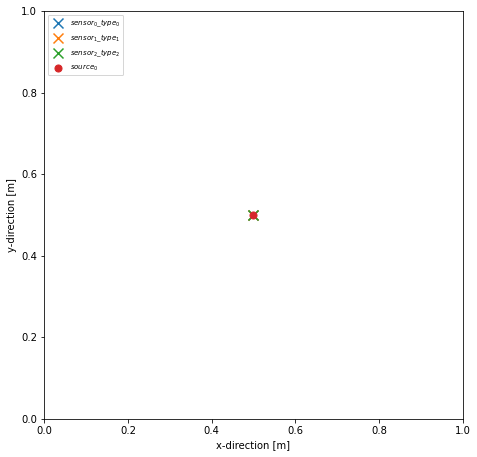

In [409]:
# DEFINE MEASUREMENT BOX & SIMULATION PARAMETERS
Lx = 1 # in [m]
Ly = 1 # in [m]
pulse_width = 10**(-10) # in [s]
tc = 4*10**(-10) # in [s]
Tmax = 10*tc # in [s]
dt_factor = 1.000035

# PICK AND PLACE SOURCES
source1 = source(pos_x=Lx/2, pos_y=Ly/2, J0=1, delay=tc, pulse_width=pulse_width)
j_s = [source1]

# SENSORS type = 0 (e_z), 1 (h_x) or 2 (h_y)
sen = [sensor(x=Lx/2, y=Ly/2, type=0) , sensor(x=Lx/2, y=Ly/2, type=1), sensor(x=Lx/2, y=Ly/2, type=2)]

# VISUALIZE PHYSICAL SPACE (DIELECTRICS, SOURCES & SENSORS)
fig, ax = plt.subplots(figsize=(15*Lx/(Lx+Ly),15*Ly/(Lx+Ly)))

for meetpunt in sen:
    ax.scatter(meetpunt.pos[0],meetpunt.pos[1], label=f"$sensor_{sen.index(meetpunt)}$_$type_{meetpunt.type}$",marker="x", s=100)

for bron in j_s:
    ax.scatter(bron.pos_x,bron.pos_y, label=f"$source_{j_s.index(bron)}$", s=50)

plt.legend(fontsize=7, loc="upper left")
plt.xlim([0,Lx])
plt.ylim([0,Ly])
plt.xlabel("x-direction [m]")
plt.ylabel("y-direction [m]")
plt.show()

In [410]:
lambda_min = j_s[0].get_lambda_min(1)
dx = lambda_min/30
dy = lambda_min/30
Nx = int(Lx/dx + 1)
Ny = int(Ly/dy + 1)
print(f"Number of space discretization steps in x direction: {Nx}")
print(f"Number of space discretization steps in y direction: {Ny}")

max_dt = 1 / (v * np.sqrt(1/(dx**2) + 1/(dy**2)))
print(f"Courant limit for the time step {max_dt} [s]")

dt = max_dt*dt_factor
print(f"Time step: {dt} [s]")
Nt = int(np.floor(Tmax/dt))
print(f"Number of time steps: {Nt}")

Number of space discretization steps in x direction: 478
Number of space discretization steps in y direction: 478
Courant limit for the time step 4.9365365979537405e-12 [s]
Time step: 4.936709376734669e-12 [s]
Number of time steps: 810


In [411]:

# Discretization of physical space (all free space)
space = np.ones((Nx-1, Ny-1))
space = space[:-1, :-1]

# Calculating the discretized postions of our line source (moet array worden in uitbreiding)
i_source = int(j_s[0].pos_x / dx)
j_source = int(j_s[0].pos_y / dy)

interference_times = np.empty(len(sen))       
for i,meetpunt in enumerate(sen):
    # Initialize measurement sensor
    meetpunt.measurement(0) #mogelijke bug als meetpunt of source ligt
    # Reflection on the PEC walls
    distance = np.empty((4,2))
    distance[0,:] = -meetpunt.pos[0],meetpunt.pos[1]
    distance[1,:] = meetpunt.pos[0],-meetpunt.pos[1]
    distance[2,:] = 2*Lx - meetpunt.pos[0], meetpunt.pos[1]
    distance[3,:] = meetpunt.pos[0],2*Ly- meetpunt.pos[1]
    distance -= (j_s[0].pos_x, j_s[0].pos_y)
    distance = np.linalg.norm(distance,axis=-1)
    min_distance = np.min(distance)
    # Set interference time
    interference_times[i] = min_distance/v

ez = np.zeros((Nx,Ny))   # x-component magnetic field [V/m]
hx = np.zeros((Nx,Ny-1)) # y-component magnetic field [V/m]
hy = np.zeros((Nx-1,Ny)) # z-component electric field [V/m]

meas_pos_x = np.asarray([ meas.pos[0] for meas in sen])//dx
meas_pos_y = np.asarray([ meas.pos[1] for meas in sen])//dy

def visualize_field(field, title, title_x, title_y, filename=None):
    plt.figure(figsize = (15,8)) #beter zichtbaar op scherm
    plt.scatter(meas_pos_x, meas_pos_y, c="gray", label="measurement points", marker="x")
    plt.scatter(j_s[0].pos_x//dx, j_s[0].pos_y//dy, c="red", label="source point", s=7)
    im = plt.imshow(np.transpose(field), origin='lower')
    plt.title(title)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    if filename is not None:
        #plt.imsave("./plots/" + filename + ".png", np.transpose(field))
        fig = plt.gcf()
        fig.set_size_inches(15,8)
        fig.savefig("./plots/" + filename + ".png") #dit geeft wel mooiere figuur
    plt.close()

def update(iteration,visualize=False):
    # Update Hy
    hy[:,:] += dt/(mu0*dx)*(ez[1:,:]-ez[:-1,:])
    # Update Hx
    hx[:,:] -= dt/(mu0*dy)*(ez[:,1:]-ez[:,:-1])
    # Update E_z
    ez[1:-1,1:-1] += dt/(ep0*dx)*(hy[1:, 1:-1] - hy[:-1, 1:-1])/space
    ez[1:-1, 1:-1] -= dt / (ep0*dy) * (hx[1:-1, 1:] - hx[1:-1, :-1]) /space
    # Update source
    ez[i_source, j_source] -= j_s[0].get_current((iteration-1/2)*dt)*dt / (dx*dy*ep0*space[i_source, j_source])
       
    # Saving measurement for measurement points
    for meetpunt in sen:
        i, j = int(meetpunt.pos[0]/dx), int(meetpunt.pos[1]/dy) #hier wss de functie van sen gebruiken
        # int 0, 1 or 2 for e_z, h_x, and h_y
        if meetpunt.type == 0:
            E_z = ez[i, j] 
            meetpunt.measurement(E_z)
            if visualize:
                visualize_field(field=abs(ez), title=f"E_z t={iteration*dt} s", title_x = "i (x-axis)", title_y="j (y-axis)", filename=f"type_{meetpunt.type}/E_z-{iteration:06d}")
        elif meetpunt.type == 1:
            H_x = hx[i, j]
            meetpunt.measurement(H_x)
        elif meetpunt.type == 2:
            H_y = hy[i, j]
            meetpunt.measurement(H_y)
        else:
            print("Sensor type not known")
    
    if iteration % (Nt//4) == 0 and iteration > 0: #klopt niet volledig maar bon
        print("Kwartje verder")

In [412]:
# zelf invullen
visualize_fields = False
# ---------------------

if visualize_fields:
    import os
    path = os.path.abspath(os.getcwd())
    if not os.path.isdir(f"{path}/plots/type_0"):
        os.mkdir("plots/type_0")

#NOTE: algoritme duurt zolang omdat er veel sensoren zijn, weinig sensoren = snellere meting
print(f"Iterating {Nt} times through the iterative algoritm to update the fields")
start = t.time()
for it in range(Nt):
    update(it,visualize=visualize_fields)
end = t.time()
print(f"Simulation time: {end-start}")

Iterating 810 times through the iterative algoritm to update the fields
Kwartje verder
Kwartje verder
Kwartje verder
Kwartje verder
Simulation time: 19.59339928627014


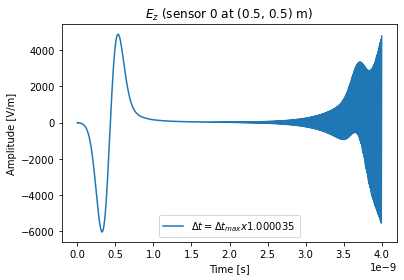

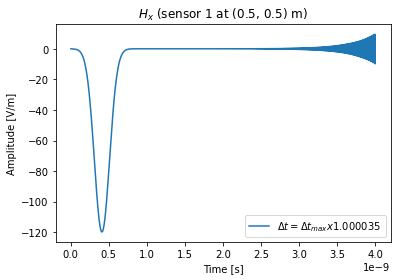

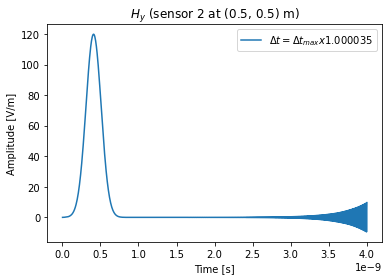

In [413]:
# Discrete time steps for H- and E-measurements
time_H = (np.arange(Nt+1) + 1/2) * dt
time_E = np.arange(Nt+1) * dt

plt.figure()
plt.plot(time_E,sen[0].measurements,label="$\u0394t=\u0394t_{max}x1.000035$")
plt.title(f"$E_z$ (sensor 0 at {sen[0].pos} m)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V/m]")
plt.legend()
plt.show()

plt.figure()
plt.plot(time_H,sen[1].measurements,label="$\u0394t=\u0394t_{max}x1.000035$")
plt.title(f"$H_x$ (sensor 1 at {sen[1].pos} m)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V/m]")
plt.legend()
plt.show()

plt.figure()
plt.plot(time_H,sen[2].measurements,label="$\u0394t=\u0394t_{max}x1.000035$")
plt.title(f"$H_y$ (sensor 2 at {sen[2].pos} m)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V/m]")
plt.legend()
plt.show()